In [2]:
# %% Import libraries and set styles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set Seaborn style
sns.set_theme(style='darkgrid', font_scale=1.2)  
PALETTE = "viridis"

In [3]:
# %% Load cleaned datasets (replace paths with your actual data)
benin = pd.read_csv('data/benin_clean.csv', parse_dates=['Timestamp'])
sierra_leone = pd.read_csv('data/seirraleone_clean.csv', parse_dates=['Timestamp'])
togo = pd.read_csv('data/togo-dapaong_qc_clean.csv', parse_dates=['Timestamp'])

# Add country identifiers
benin['Country'] = 'Benin'
sierra_leone['Country'] = 'Sierra Leone'  
togo['Country'] = 'Togo'

# Combine data
combined_df = pd.concat([benin, sierra_leone, togo], ignore_index=True)

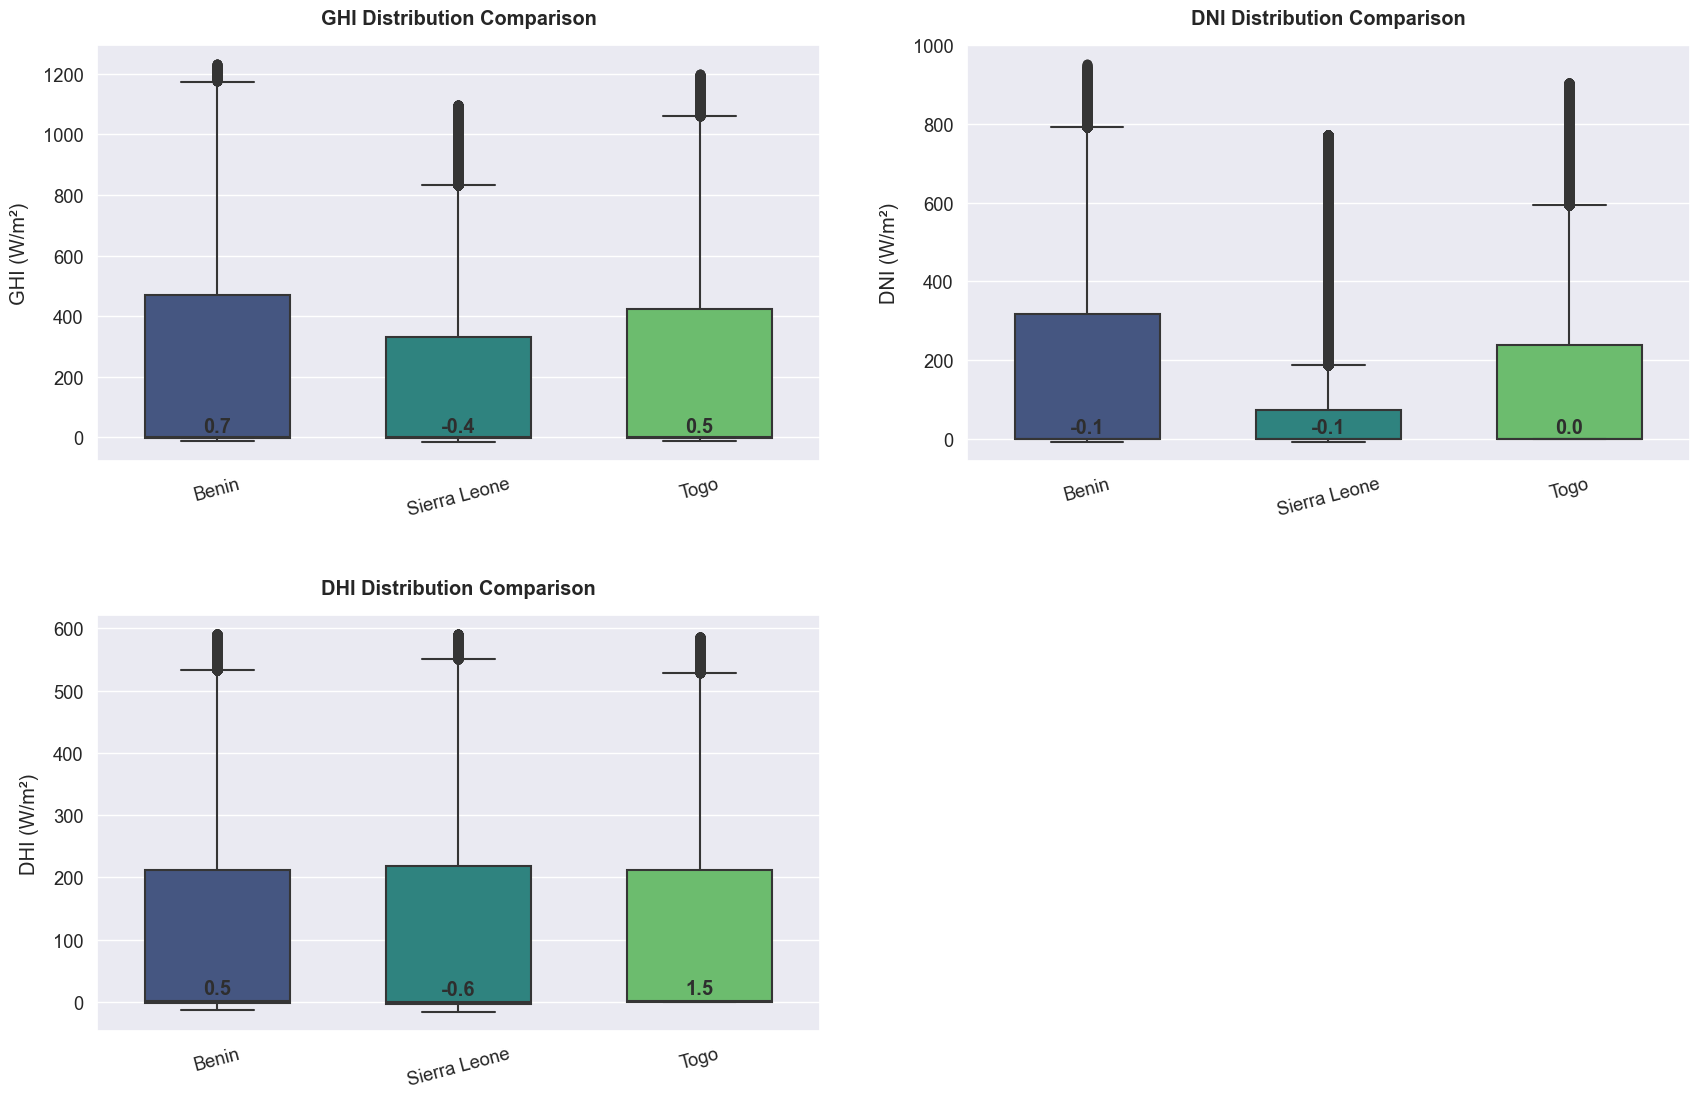

In [4]:
# %% Generate boxplots for GHI, DNI, DHI
METRICS = ['GHI', 'DNI', 'DHI']
plt.figure(figsize=(18, 12))

for i, metric in enumerate(METRICS, 1):
    plt.subplot(2, 2, i)
    ax = sns.boxplot(
        x='Country', 
        y=metric, 
        hue='Country',  # Assign x to hue
        data=combined_df,
        palette=PALETTE,
        width=0.6,
        linewidth=1.5,
        legend=False  # Suppress redundant legend
    )
    plt.title(f'{metric} Distribution Comparison', weight='bold', pad=15)
    plt.ylabel(f'{metric} (W/m²)', labelpad=10)
    plt.xlabel('')
    plt.xticks(rotation=15)
    
    # Dynamically annotate medians
    medians = combined_df.groupby('Country')[metric].median()
    for j, country in enumerate(medians.index):
        plt.text(j, medians[country] + 5, f'{medians[country]:.1f}', 
                ha='center', va='bottom', weight='bold', color='#2e2e2e')

plt.tight_layout(pad=3.0)
plt.savefig('figures/country_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
# %% Generate summary table
summary_table = combined_df.groupby('Country')[METRICS].agg(
    ['mean', 'median', 'std']
).round(2).T

# Display as HTML (no tabulate required)
from IPython.display import HTML
HTML(summary_table.to_html())

In [11]:
# %% Kruskal-Wallis Test for significance

METRICS = ['GHI', 'DNI', 'DHI']  

results = {}
for metric in METRICS:
    samples = [combined_df[combined_df['Country'] == c][metric] 
              for c in combined_df['Country'].unique()]
    h_stat, p_val = stats.kruskal(*samples)
    results[metric] = {'H-statistic': h_stat, 'p-value': p_val}

# Display results
results_df = pd.DataFrame(results).T
results_df = results_df.apply(lambda col: col.map(lambda x: f"{x:.3e}"))
Markdown(results_df.to_markdown())

|     |   H-statistic |   p-value |
|:----|--------------:|----------:|
| GHI |          6549 |         0 |
| DNI |         95730 |         0 |
| DHI |         70090 |         0 |

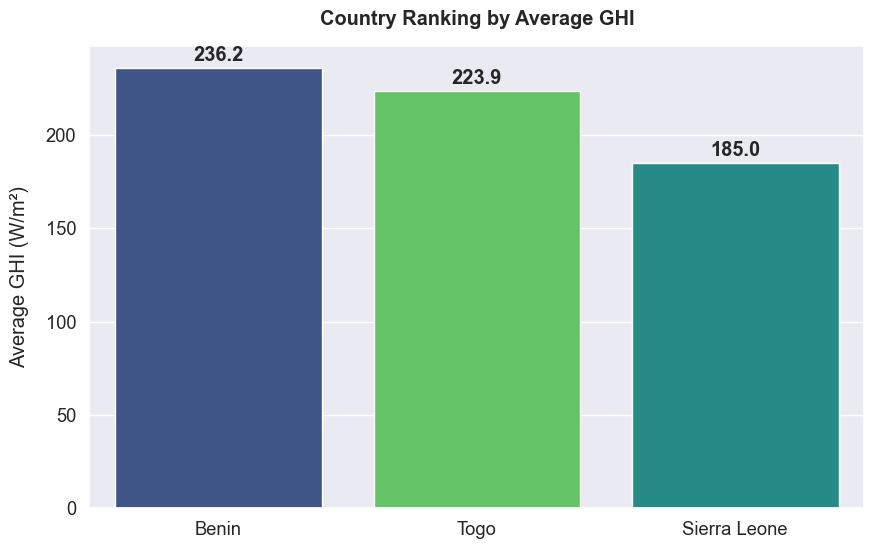

In [13]:
plt.figure(figsize=(10, 6))
order = combined_df.groupby('Country')['GHI'].mean().sort_values(ascending=False).index
ax = sns.barplot(
    x='Country', 
    y='GHI', 
    data=combined_df,
    estimator=np.mean,
    order=order,
    hue='Country', 
    palette=PALETTE,
    legend=False,   
    errorbar=None,
    saturation=0.9
)

plt.title('Country Ranking by Average GHI', weight='bold', pad=15)
plt.ylabel('Average GHI (W/m²)', labelpad=12)
plt.xlabel('')

# Annotate values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points',
                weight='bold')

plt.savefig('figures/ghi_ranking.png', dpi=300, bbox_inches='tight')
plt.show()